# AIML CA2

## Import General Dependencies

In [1]:
# Data Manipulation Dependencies
import numpy as np
import pandas as pd

# Graphing Dependencies
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous Dependencies
from typing import Union, List, Tuple, Dict, Callable
import warnings

In [2]:
# Hide all warnings
warnings.filterwarnings(action='ignore')
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Part A > Time Series Regression

## Import Exclusive Dependencies

In [3]:
# Time Series Dependencies
from pmdarima.arima import arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

## Import Data

In [4]:
df = pd.read_csv('./data/train.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index(keys='Date', inplace=True)
df.sort_index(inplace=True)
df

,T,RH,Gas,Value
Date,,,,
2004-03-10,12.020833,54.883334,CO,1316.500000
2004-03-10,12.020833,54.883334,NOx,1167.250000
2004-03-10,12.020833,54.883334,NMHC,912.250000
2004-03-10,12.020833,54.883334,O3,1096.041667
2004-03-11,9.833333,64.069791,CO,1244.062500
...,...,...,...,...
2005-01-30,4.848611,37.832986,CO,864.642361
2005-01-31,7.273958,31.809375,NMHC,939.791667
2005-01-31,7.273958,31.809375,CO,1084.500000


## Feature Engineering

In [5]:
df.groupby(by=[df.index.year, df.index.quarter]).count()

T   RH  Gas  Value
Date Date                      
2004 1      88   88   88     88
     2     364  364  364    364
     3     368  368  368    368
     4     368  368  368    368
2005 1     124  124  124    124

In [6]:
def groupby_date(df: pd.DataFrame, freq: str = 'D'):
    df_tmp = df.copy()
    gbo = df_tmp.resample(rule=freq).mean()
    return gbo

In [7]:
def drop_unreasonable_values(df: pd.DataFrame, gas: str):
    mask = df['Value'] > 0
    df_tmp = df[mask]
    dropped_rows = df[~mask]
    print(f'Dropped {dropped_rows.shape[0]} rows for {gas} (unreasonable)')
    return df_tmp

In [8]:
def drop_sparse_data(df, gas: str, threshold: int = 20, freq: str = 'days'):
    from datetime import timedelta
    index = df.index
    x = 0
    drop_rows = []
    for i in df.index:
        for n in range(1, threshold + 1):
            if (i + timedelta(**{freq: n})) not in index:
                drop_rows.append(i)
                break
        x += 1
    print(f'Dropped {len(drop_rows)} rows for {gas} (sparse)')
    return df.drop(drop_rows, axis=0)

CO = df[df['Gas'] == 'O3']
drop_sparse_data(CO, 'CO', threshold=3)

Dropped 3 rows for CO (sparse)


,T,RH,Gas,Value
Date,,,,
2004-03-10,12.020833,54.883334,O3,1096.041667
2004-03-11,9.833333,64.069791,O3,885.031250
2004-03-12,11.292708,51.107292,O3,1084.218750
2004-03-13,12.866319,51.530903,O3,1245.781250
2004-03-14,16.016667,48.843750,O3,1234.177083
...,...,...,...,...
2005-01-24,7.668750,47.883333,O3,794.770833
2005-01-25,4.509028,50.969097,O3,527.177083
2005-01-26,4.213542,49.477083,O3,567.697917


In [9]:
def fill_missing_dates(df: pd.DataFrame, freq: str = 'D'):
    dummy_date_range = pd.date_range(start=df.index[0], end=df.index[-1], freq=freq)
    dummy_date_frame = pd.DataFrame(index=dummy_date_range, data=[df[date]['Value'] if np.isin(date, df.index) else np.nan for date in dummy_date_range])
    filled_df = pd.merge(left=df, right=dummy_date_frame, left_index=True, right_index=True, how='right').drop(columns=0)
    print(f'Inserted {filled_df.shape[0] - df.shape[0]} {df.shape} rows (filled)')
    return filled_df

In [10]:
def impute_missing_values(df: pd.DataFrame, method: str = 'time'):
    return df.interpolate(method=method)

In [11]:
def get_df_partitioned_by_gas(df: pd.DataFrame, resample_freq: str = 'D'):
    gas_dict = {}
    for gas in df['Gas'].unique():
        gbo = df[df['Gas'] == gas]
        # gbo = drop_unreasonable_values(gbo, gas=gas)
        # gbo = drop_sparse_data(gbo, gas=gas, threshold=3)
        gbo = fill_missing_dates(df=gbo, freq=resample_freq)
        gbo = impute_missing_values(gbo)
        gbo['Gas'] = [gas] * gbo.shape[0]
        gas_dict[gas] = gbo
    return gas_dict

df_partitioned = get_df_partitioned_by_gas(df)
df_partitioned['CO'].tail()

Inserted 0 (328, 4) rows (filled)
Inserted 0 (328, 4) rows (filled)
Inserted 0 (328, 4) rows (filled)
Inserted 0 (328, 4) rows (filled)


,T,RH,Gas,Value
2005-01-27,5.267708,39.614930,CO,911.777778
2005-01-28,-55.515972,-24.010417,CO,592.864583
2005-01-29,-14.272917,28.563542,CO,769.625000
2005-01-30,4.848611,37.832986,CO,864.642361
2005-01-31,7.273958,31.809375,CO,1084.500000


## Exploratory Data Analysis

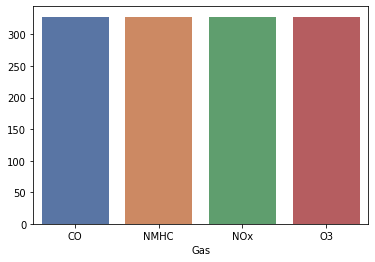

In [12]:
def get_gas_distributions(df: pd.DataFrame):
    counts = df.groupby(by='Gas').count().median(axis=1).astype(int)
    sns.barplot(x=counts.index, y=counts, palette='deep')

get_gas_distributions(df)

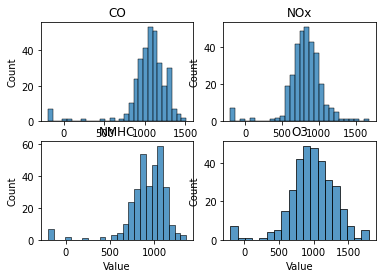

In [13]:
def get_gas_value_distributions(df_dict: Dict[str, pd.DataFrame]):
    fig, ax = plt.subplots(nrows=2, ncols=2)
    for i, gas in enumerate(df_dict.keys()):
        current_ax = ax[i // 2, i % 2]
        current_ax.set_title(gas)
        sns.histplot(data=df_dict[gas]['Value'], ax=current_ax)

get_gas_value_distributions(df_partitioned)

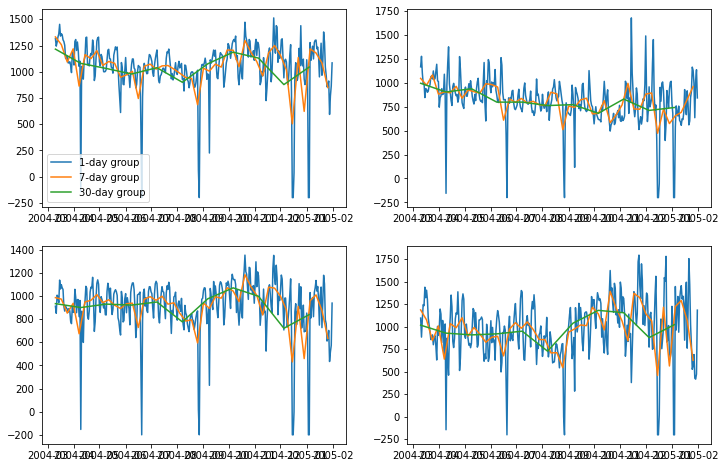

In [14]:
def get_general_trends(df_dict: Dict[str, pd.DataFrame], ma_windows: List[int] = [1, 7, 30], kind: str = 'group'):
    cells = len(df_dict.keys())
    fig, ax = plt.subplots(nrows=cells // 2, ncols=cells // 2, figsize=(12, 8))
    for i, gas in enumerate(df_dict.keys()):
        df = df_dict[gas]
        for w in ma_windows:
            df_tmp = df.rolling(window=w).mean() if kind == 'ma' else groupby_date(df, freq=f'{w}D')
            ax[i // 2, i % 2].plot(df_tmp['Value'], label=f'{w}-day {kind}')
    ax[0, 0].legend()

get_general_trends(df_dict=df_partitioned, ma_windows=[1, 7, 30])

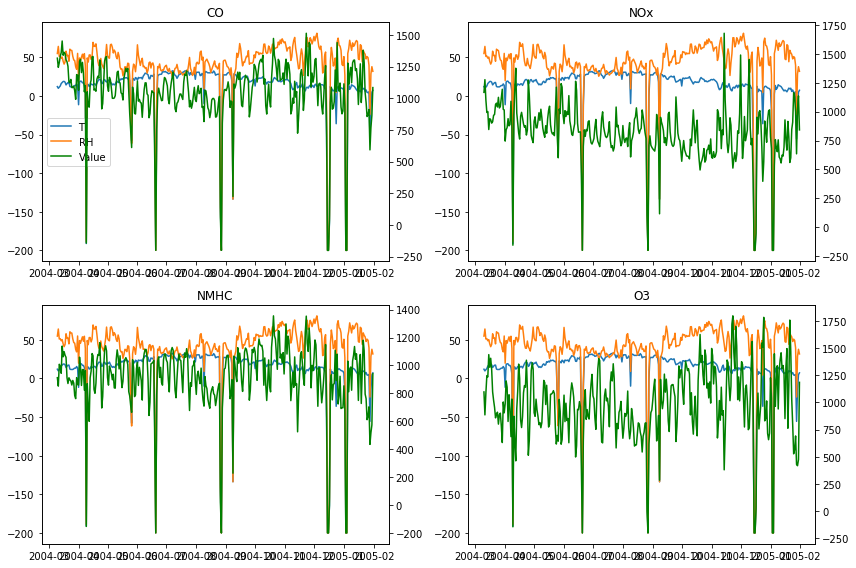

In [15]:
def get_plots_by_gas(df_dict: pd.DataFrame):
    def get_plot(df: pd.DataFrame, ax):
        ax.plot(df['T'], label='T')
        ax.plot(df['RH'], label='RH')
        ax.plot([], [], color='g', label='Value')

        ax2 = ax.twinx()
        ax2.plot(df['Value'], color='green')
        # ax.set_xticklabels(labels=df.index.month)

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    gg = [(0, 0), (0, 1), (1, 0), (1, 1)]
    
    for i, gas in enumerate(df_dict.keys()):
        current_ax = ax[(i // 2, i % 2)]
        df_tmp = df_dict[gas]
        get_plot(df_tmp, ax=current_ax)
        current_ax.set_title(gas)
        cc = current_ax.get_xticks()
    
    ax[0, 0].legend()
    fig.tight_layout()

get_plots_by_gas(df_dict=df_partitioned)

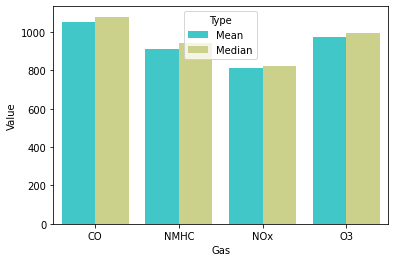

In [16]:
def get_gas_means_and_medians(df):
    # fig, ax = plt.subplots(nrows=2, ncols=2)
    gb = df.groupby(by='Gas', as_index=False)
    mean_ = gb.mean()
    mean_['Type'] = ['Mean'] * mean_.shape[0]
    types = ['Mean', 'Median']
    comb_df = pd.DataFrame()
    for i, frame in enumerate([gb.mean(), gb.median()]):
        tmp_df = frame
        tmp_df['Type'] = types[i]
        comb_df = pd.concat(objs=(comb_df, tmp_df), axis=0)
    # print(comb_df)
    sns.barplot(data=comb_df, x='Gas', y='Value', hue='Type', palette='rainbow')
get_gas_means_and_medians(df)

## Algorithm Selection

In [17]:
def cf_summary(df: pd.DataFrame, kind: Union['pacf', 'acf'], threshold: float = 0.01, max_lag: int = 40, plot: bool = False):
    from statsmodels.tsa.stattools import pacf, acf
    from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
    corr_fn = pacf if kind == 'pacf' else acf
    plot_fn = plot_pacf if kind == 'pacf' else plot_acf
    lag_space = min(max_lag, df.count() // 2 - 1)
    corr_scores, conf_intvs = corr_fn(df, nlags=lag_space, alpha=threshold)
    lower_conf_bound = conf_intvs[:, 0] - corr_scores
    upper_conf_bound = conf_intvs[:, 1] - corr_scores
    t_values = np.where((corr_scores < lower_conf_bound) | (corr_scores > upper_conf_bound))[0][1:]
    best_t = t_values[np.argmax((np.abs(corr_scores[t_values])))] if len(t_values) > 0 else 0
    if plot:
        plot_fn(df, lags=lag_space, alpha=threshold, zero=False).get_axes()[0].set_title(f'possible t-values: {tuple(t_values)} Best t: {best_t}')
    t_dict = {}
    return t_values, best_t

In [18]:
def get_seasonal_periods(df_dict: Dict[str, pd.DataFrame], plot: bool = False):
    value_dict = {}
    if plot:
        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    for i, gas in enumerate(df_dict.keys()):
        df = df_dict[gas]
        seasonal_component = seasonal_decompose(df['Value']).seasonal
        _, m = cf_summary(seasonal_component, kind='acf')
        value_dict[gas] = m
        if plot:
            focus = seasonal_component['2004-04-01':'2004-04-20']
            current_ax = ax[i // 2, i % 2]
            current_ax.plot(focus.index.day, focus)
            current_ax.set_xticks(focus.index.day)
            current_ax.set_title(gas)
    return value_dict

get_seasonal_periods(df_partitioned)

{'CO': 7, 'NOx': 7, 'NMHC': 7, 'O3': 7}

In [19]:
def test_stationarity(df: pd.DataFrame, cf_threshold: float, significance_level: float = 0.05, ax = None):
    from statsmodels.tsa.statespace.tools import diff
    p_value = adfuller(df['Value'])[1]
    p_values, best_p = cf_summary(diff(df['Value'], k_diff=0, k_seasonal_diff=1, seasonal_periods=7), kind='pacf', max_lag=6, threshold=cf_threshold)
    q_values, best_q = cf_summary(diff(df['Value'], k_diff=0, k_seasonal_diff=1, seasonal_periods=7), kind='acf', max_lag=6, threshold=cf_threshold)
    if ax is not None:
        decomposition = seasonal_decompose(df['Value'], model='additive')
        decomposition.plot(ax=ax)
    return p_value < significance_level, p_values, best_p, q_values, best_q

In [20]:
def get_param_summary(df_dict: Dict[str, pd.DataFrame], threshold: float):
    summary_dict = {}
    for gas in df_dict.keys():
        stationary, p_values, best_p, q_values, best_q = test_stationarity(df_dict[gas], cf_threshold=threshold, significance_level=0.01)
        summary_dict[gas] = {
            'stationary': stationary,
            'p_values': p_values,
            'best_p': best_p,
            'q_values': q_values,
            'best_q': best_q
        }
    return summary_dict

get_param_summary(df_partitioned, threshold=0.005)

{'CO': {'stationary': True,
  'p_values': array([1, 6], dtype=int32),
  'best_p': 1,
  'q_values': array([1, 6], dtype=int32),
  'best_q': 1},
 'NOx': {'stationary': True,
  'p_values': array([1, 2, 5, 6], dtype=int32),
  'best_p': 1,
  'q_values': array([1, 6], dtype=int32),
  'best_q': 1},
 'NMHC': {'stationary': True,
  'p_values': array([1, 6], dtype=int32),
  'best_p': 1,
  'q_values': array([1, 6], dtype=int32),
  'best_q': 1},
 'O3': {'stationary': True,
  'p_values': array([1, 6], dtype=int32),
  'best_p': 1,
  'q_values': array([1, 2], dtype=int32),
  'best_q': 1}}

In [21]:
# baseline prediction, since they are all stationary
# test_set = pd.read_csv(filepath_or_buffer='./data/test.csv', sep=',')
# pd.merge(left=test_set, right=df.groupby(by='Gas').mean(), left_on='Gas', right_index=True, how='inner')[['id', 'Value']].set_index(keys='id').to_csv('./out/using_mean.csv', sep=',')

In [22]:
def get_params(df_dict: Dict[str, pd.DataFrame], threshold: float = 0.01):
    param_summary = get_param_summary(df_dict, threshold=threshold)
    orders = {}
    for i, gas in enumerate(df_dict.keys()):
        p = tuple(param_summary[gas]['p_values'])
        d = 0 if param_summary[gas]['stationary'] else 1
        q = tuple(param_summary[gas]['q_values'])
        orders[gas] = (p, d, q)
    return orders

get_params(df_dict=df_partitioned)

{'CO': ((1, 2, 6), 0, (1, 2, 6)),
 'NOx': ((1, 2, 5, 6), 0, (1, 6)),
 'NMHC': ((1, 6), 0, (1, 2, 6)),
 'O3': ((1, 2, 6), 0, (1, 2, 6))}

In [23]:
# def partition_params(param_dict: Dict[str, Tuple], seasonal_dict: Dict[str, int]):
#     orders = {}
#     for gas in param_dict.keys():
#         order = param_dict[gas]
#         m = seasonal_dict[gas]

#         p = tuple([_p for _p in order[0] if _p % m > 0])
#         q = tuple([_q for _q in order[2] if _q % m > 0])

#         P = tuple([int(_p / m) for _p in order[0] if _p % m == 0])
#         Q = tuple([int(_q / m) for _q in order[2] if _q % m == 0])
        
#         seasonal_params = (P, 0, Q, m) if (len(P) + len(Q)) > 0 else None

#         orders[gas] = {
#             'trend_order': (p, order[1], q),
#             'seasonal_order': seasonal_params
#         }
#     return orders

# partition_params(get_params(df_dict=df_partitioned), get_seasonal_periods(df_partitioned))

In [24]:
def evaluate_params(df: pd.DataFrame, orders: Tuple, test_size: float = 0.75):
    from sklearn.metrics import mean_squared_error
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', ConvergenceWarning)
        models = {}

        data = df['Value']
        partition_index = int(data.shape[0] * test_size)

        train = data[:partition_index]
        test = data[partition_index:]

        if orders['trend_order'] is not None:
            model = SARIMAX(train, order=orders['trend_order'], seasonal_order=orders['seasonal_order']).fit()
        else:
            model = ARIMA(train, order=orders['trend_order']).fit()
            
        train_pred = model.predict(start=0, end=partition_index - 1)
        test_pred = model.forecast(steps=data.shape[0] - partition_index)
        # test_pred = model.predict(start=partition_index, end=data.shape[0] - 1)

        train_err = mean_squared_error(train[7:], train_pred[7:], squared=False)
        test_err = mean_squared_error(test, test_pred, squared=False)

        return {
            'aic': model.aic,
            'train_true': train,
            'train_pred': train_pred,
            'train_rmse': train_err,
            'test_true': test,
            'test_pred': test_pred,
            'test_rmse': test_err
        }

In [25]:
def grid_search(df_dict: Dict[str, pd.DataFrame]):
    from numpy.linalg import LinAlgError
    gs_summary = {
        'CO': [],
        'NOx': [],
        'NMHC': [],
        'O3': []
    }
    thresholds = [0.001, 0.005, 0.01]
    seasonal_params = {
        'CO': {
            'P_space': [0, 1, 2],
            'D_space': [0, 1],
            'Q_space': [0, 1, 2]
        },
        'NOx': {
            'P_space': [0, 1, 2],
            'D_space': [0, 1],
            'Q_space': [0, 1, 2]
        },
        'NMHC': {
            'P_space': [0, 1, 2],
            'D_space': [0, 1],
            'Q_space': [0, 1, 2]
        },
        'O3': {
            'P_space': [0, 1, 2],
            'D_space': [0, 1],
            'Q_space': [0, 1, 2]
        }
    }
    seasonal_periods = get_seasonal_periods(df_dict=df_dict)
    for t in thresholds:
        trend_orders = get_params(df_dict=df_dict, threshold=t)
        for gas in df_dict.keys():
            T = trend_orders[gas]
            m = seasonal_periods[gas]
            S_grid = seasonal_params[gas]
            df = df_dict[gas]
            for P in S_grid['P_space']:
                for D in S_grid['D_space']:
                    for Q in S_grid['Q_space']:
                        try:
                            results = evaluate_params(df, orders={'trend_order': T, 'seasonal_order': (P, D, Q, m)})
                            gs_summary[gas].append({
                                'orders': (T, (P, D, Q, m)),
                                'aic': results['aic'],
                                'train_rmse': results['train_rmse'],
                                'test_rmse': results['test_rmse']
                            })
                        except LinAlgError:
                            continue
    return gs_summary

gr = grid_search(df_partitioned)

In [30]:
import pickle

# pickle.dump(gr, open('./tmp/ff', 'wb'))

In [27]:
# def search_grid_search_results(gs_results):
#     #!! needs updating
#     comb = []
#     aic = []
#     rmse = []
#     for (t, l) in gs_results.keys():
#         comb.append((t, l))
#         current_res = gs_results[(t, l)]
#         aic.append(current_res['mean_aic'])
#         rmse.append(current_res['mean_test_rmse'])
#     print(min(aic), rmse[np.argmin(aic)], np.argmin(aic))
#     print(min(rmse), aic[np.argmin(rmse)], np.argmin(rmse))
#     return comb, aic, rmse

# # import pickle
# # ultimate = pickle.load(open('./tmp/grid-search.p', 'rb'))
# search_grid_search_results(ultimate2)[0][19]

In [31]:
def evaluate_grid_search(gs_results, metric: Union['rmse', 'aic'] = 'rmse'):
    gs_best_params = {}
    for gas in gs_results.keys():
        res = gs_results[gas]
        index = np.argmin(list(map(lambda x: x['test_rmse'], res))) if metric == 'rmse' else np.argmin(list(map(lambda x: x['aic'], res)))
        print(gas)
        for i in ['orders', 'aic', 'train_rmse', 'test_rmse']:
            print(i, ':', res[index][i])
        best_orders = res[index]['orders']
        gs_best_params[gas] = {
            'trend_order': best_orders[0],
            'seasonal_order': best_orders[1]
        }
    return gs_best_params

gs_res = evaluate_grid_search(gr, metric='rmse')

CO
orders : (((1, 6), 0, (1, 6)), (1, 0, 1, 7))
aic : 3285.5180798634356
train_rmse : 187.03839721581045
test_rmse : 347.22844364304876
NOx
orders : (((1, 5, 6), 0, (1, 6)), (0, 1, 1, 7))
aic : 3154.339986637462
train_rmse : 172.7823964569562
test_rmse : 315.8584261090708
NMHC
orders : (((1, 6), 0, (1,)), (0, 0, 1, 7))
aic : 3271.5977564592395
train_rmse : 183.22788453351774
test_rmse : 309.0529262491669
O3
orders : (((1, 2, 6), 0, (1, 2, 6)), (0, 0, 0, 7))
aic : 3364.1355890579534
train_rmse : 218.66137821526743
test_rmse : 443.1091104773797


In [32]:
from sklearn.metrics import mean_squared_error

def evaluate_params_whole(df_dict: Dict[str, pd.DataFrame], orders: Dict[str, Dict[str, Tuple]], test_size: float = 0.75):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', ConvergenceWarning)
        models = {}
        for gas in df_dict.keys():

            data = df_dict[gas]['Value']
            partition_index = int(data.shape[0] * test_size)

            train = data[:partition_index]
            test = data[partition_index:]

            current_orders = orders[gas]

            if current_orders['trend_order'] is not None:
                model = SARIMAX(train, order=current_orders['trend_order'], seasonal_order=current_orders['seasonal_order']).fit()
            else:
                model = ARIMA(train, order=current_orders['trend_order']).fit()
            
            train_pred = model.predict(start=0, end=partition_index - 1)
            test_pred = model.forecast(steps=data.shape[0] - partition_index)
            # test_pred = model.predict(start=partition_index, end=data.shape[0] - 1)

            train_err = mean_squared_error(train[7:], train_pred[7:], squared=False)
            test_err = mean_squared_error(test, test_pred, squared=False)

            models[gas] = {
                'aic': model.aic,
                'train_true': train,
                'train_pred': train_pred,
                'train_rmse': train_err,
                'test_true': test,
                'test_pred': test_pred,
                'test_rmse': test_err
            }
        return models

gg = evaluate_params_whole(df_partitioned, orders = gs_res)

In [33]:
def decompose(results: Dict[str, Dict], test_rmse_weight: float = 0.5):
    aic_values = []
    train_rmse_values = []
    test_rmse_values = []
    for gas in results.keys():
        aic_values.append(results[gas]['aic'])
        train_rmse_values.append(results[gas]['train_rmse'])
        test_rmse_values.append(results[gas]['test_rmse'])
    decomposed_results = {
        'mean_aic': sum(aic_values) / len(aic_values),
        'mean_train_rmse': sum(train_rmse_values) / len(train_rmse_values),
        'mean_test_rmse': sum(test_rmse_values) / len(test_rmse_values),
    }
    decomposed_results['overall_mean_rmse'] = (1 - test_rmse_weight) * decomposed_results['mean_train_rmse'] + test_rmse_weight * decomposed_results['mean_test_rmse']
    return decomposed_results

decompose(gg, test_rmse_weight=0.75)

{'mean_aic': 3268.8978530045224,
 'mean_train_rmse': 190.42751410538796,
 'mean_test_rmse': 353.81222661966655,
 'overall_mean_rmse': 312.9660484910969}

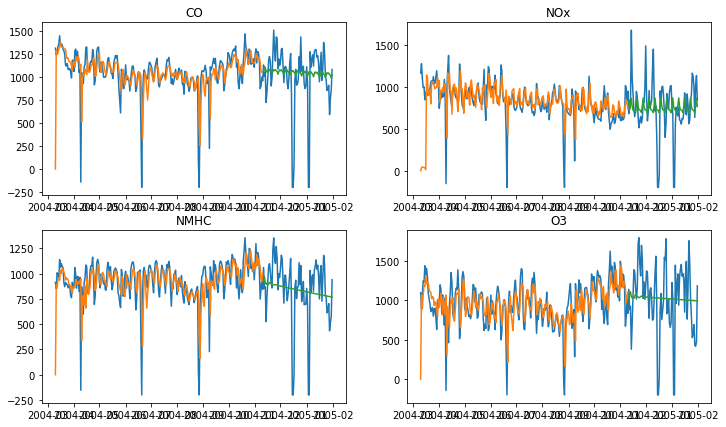

In [35]:
def plot_predictions(results: Dict[str, Dict]):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 7))
    for i, gas in enumerate(results.keys()):
        current_results = results[gas]
        current_ax = ax[i // 2, i % 2]
        current_ax.plot(pd.concat(objs=(current_results['train_true'], current_results['test_true']), axis=0))
        current_ax.plot(current_results['train_pred'])
        current_ax.plot(current_results['test_pred'])
        current_ax.set_title(gas)

plot_predictions(gg)

In [ ]:
# def generate_combinations(orders: Tuple[Tuple[int], int, Tuple[int]], limit: int = None, empty: bool = False):
#     from more_itertools import powerset
#     from itertools import product
#     from numpy.random import shuffle

#     p = [v for v in powerset(orders[0]) if (len(v) > 0 or empty)]
#     q = [v for v in powerset(orders[2]) if (len(v) > 0 or empty)]

#     combinations = list(product(p, (orders[1],), q))
#     shuffle(combinations)

#     if limit is not None:
#         return combinations[:limit]
#     return combinations

# generate_combinations(((2, 3), 0, (1,)), empty=True)

In [ ]:
def get_test_df(file_path: str = './data/test.csv'):
    test_df = pd.read_csv(filepath_or_buffer=file_path, sep=',', header=0)
    test_df['Date'] = pd.to_datetime(test_df['Date'], format='%d/%m/%Y')
    test_df.set_index(keys='Date', inplace=True)
    return test_df.sort_index(ascending=True)

In [ ]:
gs_res

In [ ]:
def kaggle_submission(df_dict: Dict[str, pd.DataFrame], orders: Dict[str, Dict], test_file: str, submission_file: str):
    test_df = get_test_df()
    result_set = {}
    from statsmodels.tools.sm_exceptions import ConvergenceWarning
    from numpy.linalg import LinAlgError
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', ConvergenceWarning)
        for gas in df_dict.keys():
            df = df_dict[gas]['Value']
            # print(df.shape)
            target = test_df[test_df['Gas'] == gas]
            try:
                model = SARIMAX(df, order=orders[gas]['trend_order'], trend='n', seasonal_order=orders[gas]['seasonal_order']).fit()
            except LinAlgError:
                model = SARIMAX(df, order=orders[gas]['trend_order'], trend='c', seasonal_order=orders[gas]['seasonal_order']).fit()
            pred = model.forecast(target.index[-1]).rename('Value')
            result = pd.merge(left=pred, right=target, left_index=True, right_index=True, how='inner')
            print(result.shape)
            result_set[gas] = result[['id', 'T', 'RH', 'Value']].set_index(keys='id')

    pred_df = pd.DataFrame(columns=result_set['CO'].columns)
    for gas in result_set.keys():
        pred_df = pd.concat(objs=(pred_df, result_set[gas]), axis=0)
    
    pred_df.sort_index(inplace=True)
    pred_df['Value'].to_csv(submission_file, sep=',', index_label='id')
    
    return pred_df.sort_index(ascending=True)

pred_df = kaggle_submission(df_partitioned, orders=gs_res, test_file='./data/test.csv', submission_file='./out/sarima-no-drop.csv')

In [ ]:
def plot_forecasts(df_dict: Dict[str, pd.DataFrame], submission_file: str):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
    test_df = get_test_df()
    pred_df = pd.read_csv(submission_file, index_col=0)
    for i, gas in enumerate(test_df['Gas'].unique()):
        df = df_dict[gas]
        current_ax = ax[i // 2, i % 2]
        target = test_df[test_df['Gas'] == gas]
        future = pd.merge(left=target, right=pred_df, left_on='id', right_index=True, how='inner')
        current_ax.plot(df['Value'])
        current_ax.plot(future['Value'])
        current_ax.set_title(gas)

plot_forecasts(df_partitioned, submission_file='./out/sarima-no-drop.csv')

In [ ]:
def bar_forecasts():
    df = pd.read_csv('./out/sarima-no-drop.csv', index_col=0)
    df.plot()

bar_forecasts()

In [ ]:
from statsmodels.tsa.holtwinters import Holt
from sklearn.metrics import mean_squared_error
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# model = Holt(df_partitioned['CO']['Value']).fit()
# y_hat_b4 = model.forecast(steps=100)

def exp_smoothing(df_dict: Dict[str, pd.DataFrame], seasonal_periods: List[int], alpha_space: np.ndarray):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', ConvergenceWarning)
        best_vals = {}
        best_by_rmse = {}
        for gas in df_dict.keys():
            aic = []
            rmse_vals = []
            s_vals = []
            a_vals = []
            for s in seasonal_periods:
                for a in alpha_space:
                    df = df_dict[gas]
                    y_true = df['Value']
                    model = ExponentialSmoothing(endog=df['Value'], seasonal='mul', seasonal_periods=s).fit(smoothing_level=a)
                    y_hat = model.predict(start=0, end=391)
                    y_pred = model.forecast(steps=50)
                    # plt.plot(y_true)
                    # plt.plot(y_hat)
                    # plt.plot(y_pred)
                    rmse = mean_squared_error(y_true, y_hat, squared=False)
                    # print(gas, s, a, model.aic, rmse)
                    aic.append(model.aic)
                    rmse_vals.append(rmse)
                    s_vals.append(s)
                    a_vals.append(a)
            best_vals[gas] = {
                's': s_vals[np.argmin(aic)],
                'a': a_vals[np.argmin(aic)],
                'aic': np.min(aic),
                'rmse': rmse_vals[np.argmin(aic)]
            }
            best_by_rmse[gas] = {
                's': s_vals[np.argmin(rmse_vals)],
                'a': a_vals[np.argmin(rmse_vals)],
                'aic': aic[np.argmin(rmse_vals)],
                'rmse': min(rmse_vals)
            }
        return best_vals, best_by_rmse

exp_smoothing(df_partitioned, [i for i in range(2, 13)], alpha_space=np.linspace(0.01, 1, 20))

In [ ]:
def ExpSmth(df_dict: Dict[str, pd.DataFrame], submission_file: str):
    params, _ = exp_smoothing(df_dict, [2, 4, 6, 8, 12], alpha_space=np.linspace(0.01, 1, 10))
    test_df = get_test_df()
    result_set = {}
    from statsmodels.tools.sm_exceptions import ConvergenceWarning
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', ConvergenceWarning)
        for gas in df_dict.keys():
            df = df_dict[gas]['Value']
            target = test_df[test_df['Gas'] == gas]
            s, a = params[gas]['s'], params[gas]['a']
            print(target.index[-1])
            model = ExponentialSmoothing(endog=df, seasonal_periods=7).fit(smoothing_level=0.25)
            # pred = model.forecast(target.index[-1]).rename('Value')
            pred = model.forecast(steps=100).rename('Value')
            result = pd.merge(left=pred, right=target, left_index=True, right_index=True, how='inner')
            print(result.shape)
            result_set[gas] = result[['id', 'Value']].set_index(keys='id')

    pred_df = pd.DataFrame(columns=result_set['CO'].columns)
    for gas in result_set.keys():
        pred_df = pd.concat(objs=(pred_df, result_set[gas]), axis=0)
    
    # pred_df.to_csv(submission_file)

ExpSmth(df_partitioned, submission_file='./out/base-iii.csv')

In [ ]:
plt.plot(df_partitioned['CO']['Value'])
plt.plot(ExponentialSmoothing(endog=df_partitioned['CO']['Value'], seasonal_periods=7, seasonal='add', trend=None).fit(smoothing_level=0.05).predict(start=1, end=df_partitioned['CO']['Value'].shape[0]))
print(df_partitioned['CO']['Value'].index[0])
print(ExponentialSmoothing(endog=df_partitioned['CO']['Value'], seasonal_periods=7, seasonal='add', trend=None).fit(smoothing_level=0.05).predict(start=0, end=df_partitioned['CO']['Value'].shape[0] - 1).index[0])
from sklearn.metrics import mean_squared_error

mean_squared_error(df_partitioned['CO']['Value'], ExponentialSmoothing(endog=df_partitioned['CO']['Value'], seasonal_periods=7, seasonal='add', trend=None).fit(smoothing_level=0.43).predict(start=0, end=df_partitioned['CO']['Value'].shape[0] - 1), squared=False)

In [ ]:
def plot_train_and_test():
    for gas in df_partitioned.keys():
        plt.clf()
        df = df_partitioned[gas]
        test = get_test_df()
        test = test[test['Gas'] == gas]
        plt.plot()

In [ ]:
# use supervised learning to check
# use varima to check correlation between T and RH

In [ ]:
from pmdarima.arima import auto_arima

# auto_arima(df_partitioned['CO']['Value'], seasonal=True, m=19).summary()
plt.plot(df_partitioned['O3']['Value'])
plt.plot(SARIMAX(df_partitioned['O3']['Value'][:-63], order=(2, 0, 2), seasonal_order=(1, 0, 0, 7), trend='c').fit().forecast(df_partitioned['O3'].index[-1]))

# Part B > Clustering

## Import Exclusive Dependencies

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation, AgglomerativeClustering

## Import Data

In [ ]:
df2 = pd.read_csv('./data/Mall_Customers.csv', index_col=0)
df2.head()

## Exploratory Data Analysis

In [ ]:
def rename_columns(df: pd.DataFrame):
    df_tmp = df.copy()
    df_tmp.rename(mapper={
        'Genre': 'Gender',
        'Annual Income (k$)': 'Annual Income',
        'Spending Score (1-100)': 'Spending Score'
    }, axis=1, inplace=True)
    df_tmp['Annual Income'] = df_tmp['Annual Income'] * 1000
    return df_tmp

df2 = rename_columns(df2)
df2

In [ ]:
def get_distribution_of_each_variable(df: pd.DataFrame):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
    for i, c in enumerate(df.columns):
        var = df[c]
        kde = var.dtype.kind in 'biufc'
        sns.histplot(var, kde=kde, ax=ax[i // 2, i % 2])

get_distribution_of_each_variable(df2)

In [ ]:
def get_distribution_by_gender(df: pd.DataFrame):
    fig, ax = plt.subplots(nrows=3, figsize=(8, 8))
    for i, c in enumerate(['Age', 'Annual Income', 'Spending Score']):
        var = df[c]
        sns.kdeplot(x=var, hue=df['Gender'], ax=ax[i])
    fig.tight_layout()

get_distribution_by_gender(df2)

# It seems that there are slightly more data on female customers than male ones

In [ ]:
def get_corr_heatmap(df: pd.DataFrame):
    sns.heatmap(df.corr(), annot=True, cmap='bone')

get_corr_heatmap(df2)

## Feature Engineering

In [ ]:
def standardize_variables(df: pd.DataFrame, cols: List[str]):
    df_tmp = df.copy()
    df_tmp[cols] = StandardScaler().fit_transform(df_tmp[cols])
    return df_tmp

df2_s = standardize_variables(df2, cols=['Age', 'Annual Income', 'Spending Score'])
df2_s

## Principal Component Analysis

In [ ]:
from typing import Union, List

def get_pca_results(df: pd.DataFrame, ignore_cols: Union[str, List[str]]):
    df_scaled = StandardScaler().fit_transform(X=df.drop(columns=ignore_cols))

    pca = PCA(n_components=df_scaled.shape[1]).fit(X=df_scaled)
    header = ['Eigenvalue', 'Explained Variance', 'Cumulative Explained Variance']
    header.extend(df.drop(columns=ignore_cols).columns.tolist())
    eigenvalues = pca.explained_variance_
    eigenvectors = pca.components_
    expl_var = pca.explained_variance_ratio_
    cum_expl_var = pca.explained_variance_ratio_.cumsum()
    pca_results = pd.DataFrame(
        data=np.hstack((
            eigenvalues.reshape(-1, 1),
            expl_var.reshape(-1, 1),
            cum_expl_var.reshape(-1, 1),
            eigenvectors
        )),
        columns=header,
        index=[f'PC {i + 1}' for i in range(df_scaled.shape[1])]
    )

    df_transformed = pd.DataFrame(
        data=pca.transform(df_scaled),
        index=df.index,
        columns=[f'PC {i + 1}' for i in range(df_scaled.shape[1])]
    )

    return pca_results, df_transformed

pca_results, df2_transformed = get_pca_results(df=df2, ignore_cols='Gender')
pca_results

In [ ]:
def scree_plot(df: pd.DataFrame, pca: pd.DataFrame):
    with sns.axes_style(style='darkgrid'):
        ax = sns.pointplot(data=pca, x=pca.index, y=pca['Eigenvalue'])
        ax.set(
            title='Scree Plot for PCA (df2)',
            ylim=(0, 1.4)
        )
        ax.annotate(text='As there is no elbow,\nno PC should be discarded', xy=(1.75, 1.2), ha='center')
        return ax

scree_plot(df2, pca_results)

## Visual Analysis - Algorithm

In [ ]:
# import plotly.express as px
# from sklearn.cluster import DBSCAN, OPTICS, AgglomerativeClustering, AffinityPropagation

# for mo in [KMeans(n_clusters=6), DBSCAN(eps=15, min_samples=15), OPTICS(max_eps=18)]:
#     colrs = mo.fit_predict(X=df2[['Annual Income (k$)', 'Age', 'Spending Score (1-100)']])
#     fig = px.scatter_3d(data_frame=df2, x='Annual Income (k$)', y='Age', z='Spending Score (1-100)', color=colrs, title=type(mo).__name__ + ' ' + str(round(silhouette_score(X=df2[['Annual Income (k$)', 'Age', 'Spending Score (1-100)']], labels=colrs), 2)), color_continuous_scale=px.colors.sequential.Rainbow)
#     fig.show()

In [ ]:
cluster_params = [4, 5]
fig, ax = plt.subplots(ncols=2, figsize=(10, 8))
for i, cl in enumerate(cluster_params):
    model = KMeans(n_clusters=cl).fit(X=df2_s[['Annual Income', 'Spending Score']])
    y_hat = model.predict(df2_s[['Annual Income', 'Spending Score']])
    sns.scatterplot(data=df2_s, x='Annual Income', y='Spending Score', hue=y_hat, ax=ax[i])
    print(f'Silhouette Score ({cl}):', silhouette_score(X=df2_s[['Annual Income', 'Spending Score']], labels=model.labels_, metric='euclidean'))

## Numerical Optimisation - Hyperparameter Selection

In [ ]:
def get_dist_score(df: pd.DataFrame, cols: List[str], clusters: int, plot: bool = False):
    model = KMeans(n_clusters=clusters, random_state=3).fit(X=df[cols])
    centers = model.cluster_centers_
    y_hat = model.predict(X=df[cols])
    
    df_tmp = pd.concat(objs=(df, pd.Series(data=y_hat, name='Class', index=df.index)), axis=1)
    means = []
    counts = []
    for i, c in enumerate(centers):
        class_i = df_tmp[df_tmp['Class'] == i][cols]
        distances = np.linalg.norm(class_i - centers[i, :], axis=1)
        means.append(distances.mean())
        counts.append(len(class_i))
    
    if plot == True:
        for i, m in enumerate(means):
            plt.plot(centers[i,0], centers[i,1], 'o', mfc='none', color='r', markersize=m * 5)
        sns.scatterplot(x=df['Annual Income'], y=df['Spending Score'], hue=y_hat)

    return np.std(means) / (sum(means) / len(means)), np.std(counts)
    # return np.std(means)

get_dist_score(df2, ['Age', 'Annual Income', 'Spending Score'], 6)

In [ ]:
def get_silhouette_score(df: pd.DataFrame, cols: List[str], clusters: int):
    X = df[cols]
    y_hat = KMeans(n_clusters=clusters).fit(X=X).predict(X=X)
    return silhouette_score(X=df[cols], labels=y_hat)

get_silhouette_score(df=df2, cols=['Age', 'Annual Income', 'Spending Score'], clusters=6)

In [ ]:
# type: ignore
from sklearn.metrics import silhouette_score
from more_itertools import powerset

def get_custom_score_plot(df: pd.DataFrame, cols: List[str], clusters: List[int] = list(range(2, 11)), ignore_cols: Union[str, List[str]] = None):
    distance_scores = [get_dist_score(df, cols, n)[0] for n in clusters]
    count_scores = [get_dist_score(df, cols, n)[1] for n in clusters]
    silhouette_scores = [get_silhouette_score(df, cols, n) for n in clusters]

    ax = sns.lineplot(x=clusters, y=silhouette_scores)
    ax2 = ax.twinx()
    ax3 = ax.twinx()
    sns.lineplot(x=clusters, y=distance_scores, color='g', ax=ax2)
    sns.lineplot(x=clusters, y=count_scores, color='r', ax=ax3)

get_custom_score_plot(df=df2, cols=['Age', 'Annual Income', 'Spending Score'])

In [ ]:
get_custom_score_plot(df=df2, cols=['Annual Income', 'Spending Score'])

In [ ]:
import plotly.express as px

def get_final_plot(df: pd.DataFrame):
    df_tmp = df.copy()
    X = df[['Age', 'Annual Income', 'Spending Score']]
    model = KMeans(n_clusters=6)
    model.fit(X=X)
    y_hat = model.predict(X=X)
    df_tmp['Class'] = y_hat
    fig = px.scatter_3d(data_frame=df_tmp, x='Age', y='Annual Income', z='Spending Score', color='Class')
    return fig

get_final_plot(df2)